# 5. Back Propagation

In [1]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
    
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y
        return out
    
    def backward(self, dout):
        dx = dout * self.y
        dy =dout * self.x
        return dx, dy

In [2]:
apple = 100
apple_num = 2
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print(price)

# backward
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple, dapple_num, dtax)

220.00000000000003
2.2 110.00000000000001 200


In [3]:
class AddLayer:
    def __init__(self):
        pass
    
    def forward(self, x, y):
        out = x + y
        return out
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy

In [4]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(all_price, tax)

# backward
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(price)
print(dapple_num, dapple, dorange_num, dorange, dtax)

715.0000000000001
110.00000000000001 2.2 165.0 3.3000000000000003 650


In [5]:
class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

In [6]:
import numpy as np

class Sigmoid:
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

In [7]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
        
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        return dx

In [8]:
from common.functions import softmax, cross_entropy_error

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx

In [9]:
import sys, os
#from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size,weight_init_std=0.01):
        # initialize weight
        self.params = {}
        self.params["W1"] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params["b1"] = np.zeros(hidden_size)
        self.params["W2"] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params["b2"] = np.zeros(output_size)
        
        # generate layers
        self.layers = OrderedDict()
        self.layers["Affine1"] = Affine(self.params["W1"], self.params["b1"])
        self.layers["Relu1"] = Relu()
        self.layers["Affine2"] = Affine(self.params["W2"], self.params["b2"])
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x,t)
        grads = {}
        grads["W1"] = numerical_gradient(loss_W, self.params["W1"])
        grads["b1"] = numerical_gradient(loss_W, self.params["b1"])
        grads["W2"] = numerical_gradient(loss_W, self.params["W2"])
        grads["b2"] = numerical_gradient(loss_W, self.params["b2"])
        return grads
    
    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        
        #backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        # setting
        grads = {}
        grads["W1"] = self.layers["Affine1"].dW
        grads["b1"] = self.layers["Affine1"].db
        grads["W2"] = self.layers["Affine2"].dW
        grads["b2"] = self.layers["Affine2"].db
        
        return grads

In [10]:
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ":" + str(diff))

b2:1.19459996062e-10
W1:2.16648466144e-13
W2:7.72259956477e-13
b1:6.98272481503e-13


train acc, test acc |0.118483333333,0.1158
train acc, test acc |0.903266666667,0.9059
train acc, test acc |0.919983333333,0.9241
train acc, test acc |0.9338,0.9338
train acc, test acc |0.941533333333,0.9389
train acc, test acc |0.9499,0.9482
train acc, test acc |0.954566666667,0.9528
train acc, test acc |0.960583333333,0.9548
train acc, test acc |0.963833333333,0.9599
train acc, test acc |0.967133333333,0.9613
train acc, test acc |0.96885,0.9633
train acc, test acc |0.9717,0.966
train acc, test acc |0.9733,0.968
train acc, test acc |0.975166666667,0.9682
train acc, test acc |0.975966666667,0.9661
train acc, test acc |0.977716666667,0.9679
train acc, test acc |0.979,0.9708


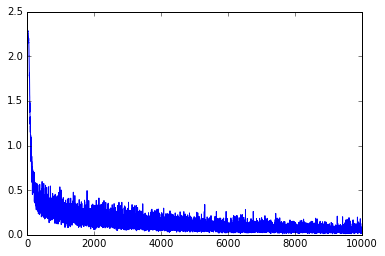

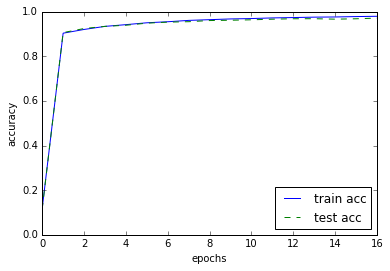

In [11]:
import matplotlib.pylab as plt
%matplotlib inline

# hyper parameter
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

# list for record
train_loss_list=[]
train_acc_list=[]
test_acc_list=[]
iter_per_epoch = max(int(train_size / batch_size), 1)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # get a mini-batch
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # compute gradients
    grad = network.gradient(x_batch, t_batch)
    
    # update parameters
    for key in network.params.keys():
        network.params[key] -= learning_rate * grad[key]
        
    # record the process of learning
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # compute accuracy per an epoch
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc |" + str(train_acc)+ "," + str(test_acc))

plt.plot(np.arange(iters_num),train_loss_list)
plt.show()

markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()